# IMPORT

In [5]:
import torch
import numpy as np
import pandas as pd
from typing import Dict
import torch
from datasets import load_dataset
from transformers import DataCollatorWithPadding
from datasets import load_dataset
from datasets import load_metric
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    EvalPrediction,
    Trainer,
    TrainingArguments,
    set_seed,
)

In [6]:
### Model Parameters
# we will use with Distil-BERT
# language_model_name = "distilbert-base-uncased"
language_model_name = "bert-base-uncased"

### Training Argurments

# this GPU should be enough for this task to handle 32 samples per batch
batch_size = 32

# optim
learning_rate = 1e-4
weight_decay = 0.001 # we could use e.g. 0.01 in case of very low and very high amount of data for regularization

# training
epochs = 1
device = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(42)

nli_dataset = load_dataset("tommasobonomo/sem_augmented_fever_nli",trust_remote_code=True)
adversarial_set = load_dataset("iperbole/adversarial_fever_nli")



### METRIC DEFINITION

# Metrics
def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy",trust_remote_code=True)
    load_f1 = load_metric("f1",trust_remote_code=True)
    load_precision = load_metric("precision",trust_remote_code=True)
    load_recall = load_metric("recall",trust_remote_code=True)

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    precision = load_precision.compute(predictions=predictions, references=labels, average="weighted")["precision"]
    recall = load_recall.compute(predictions=predictions, references=labels, average="weighted")["recall"]

    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}






In [11]:
# print(nli_dataset["train"]['label'])
print(train_label_counts)

CONTRADICTION    12331
ENTAILMENT       31128
NEUTRAL           7627
Name: count, dtype: int64


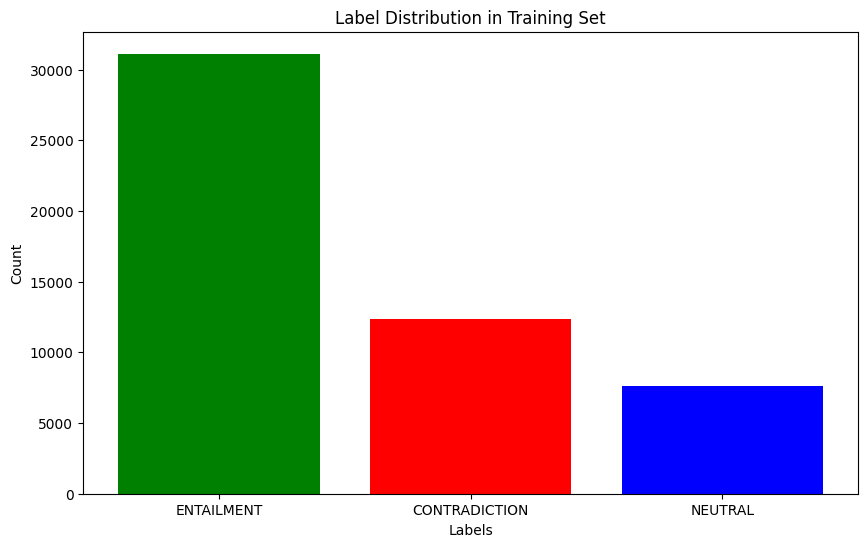

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract labels from the tokenized dataset
train_labels = nli_dataset['train']['label']
validation_labels = nli_dataset['validation']['label']
test_labels = nli_dataset['test']['label']

# Count occurrences of each label
train_label_counts = pd.Series(train_labels).value_counts()
validation_label_counts = pd.Series(validation_labels).value_counts()
test_label_counts = pd.Series(test_labels).value_counts()

# Define label names for better readability in plots
label_names = ["ENTAILMENT", "CONTRADICTION", "NEUTRAL"]

# Create a mapping of labels to counts for correct order
train_label_counts = train_label_counts.reindex(label_names)
validation_label_counts = validation_label_counts.reindex(label_names)
test_label_counts = test_label_counts.reindex(label_names)

# Plot distribution for the training set
plt.figure(figsize=(10, 6))
plt.bar(train_label_counts.index, train_label_counts.values, tick_label=label_names,color = ['green','red','blue'])
plt.title('Label Distribution in Training Set')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()


In [4]:
# MODEL
## Initialize the model
model = AutoModelForSequenceClassification.from_pretrained(language_model_name,
                                                                   ignore_mismatched_sizes=True,
                                                                   output_attentions=False, output_hidden_states=False,
                                                                   num_labels=3) # number of the classes to change to 3

tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# padding with the most long sentence!
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # avoid to use can reduce the memory on GPU

#examples are batch!
def tokenize_function(examples):
    examples["label"] = [labels_mapping[label] for label in examples["label"]]
    return tokenizer(examples["premise"], examples["hypothesis"],padding = True, truncation=True)




# Tokenize the dataset ...
print("Tokenize the dataset ...")
labels_mapping = {"ENTAILMENT":0, "CONTRADICTION":1, "NEUTRAL":2 }
tokenized_datasets_nli = nli_dataset.map(tokenize_function, batched=True)
tokenized_adversarial_dataset = adversarial_set.map(tokenize_function, batched=True)

print(tokenized_datasets_nli["train"][0])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenize the dataset ...


Map:   0%|          | 0/2288 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

{'id': '150448', 'premise': "Roman Atwood . He is best known for his vlogs , where he posts updates about his life on a daily basis . His vlogging channel , `` RomanAtwoodVlogs '' , has a total of 3.3 billion views and 11.9 million subscribers . He also has another YouTube channel called `` RomanAtwood '' , where he posts pranks .", 'hypothesis': 'Roman Atwood is a content creator.', 'label': 0, 'wsd': {'premise': [{'index': 0, 'text': 'Roman', 'pos': 'ADJ', 'lemma': 'roman', 'bnSynsetId': 'bn:00109913a', 'wnSynsetOffset': '2921569a', 'nltkSynset': 'roman.a.01'}, {'index': 1, 'text': 'Atwood', 'pos': 'PROPN', 'lemma': 'Atwood', 'bnSynsetId': 'O', 'wnSynsetOffset': 'O', 'nltkSynset': 'O'}, {'index': 2, 'text': '.', 'pos': 'PUNCT', 'lemma': '.', 'bnSynsetId': 'O', 'wnSynsetOffset': 'O', 'nltkSynset': 'O'}, {'index': 3, 'text': 'He', 'pos': 'PRON', 'lemma': 'he', 'bnSynsetId': 'O', 'wnSynsetOffset': 'O', 'nltkSynset': 'O'}, {'index': 4, 'text': 'is', 'pos': 'AUX', 'lemma': 'be', 'bnSynset

In [5]:

#MODEL TRAINING

training_args = TrainingArguments(
    output_dir="training_dir",                    # output directory [Mandatory]
    num_train_epochs=epochs,                      # total number of training epochs
    per_device_train_batch_size=batch_size,       # batch size per device during training
    warmup_steps=500,                             # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,                    # strength of weight decay
    save_strategy="no",                           # save the model
    learning_rate=learning_rate,                  # learning rate
    gradient_checkpointing = True                 # to reduce memory usage
    # fp16 = True                                 # to reduce more memory usage
)


trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_datasets_nli["train"],
   eval_dataset=tokenized_datasets_nli["validation"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


trainer.train()

  0%|          | 0/1597 [00:00<?, ?it/s]

/home/bitfra/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.6351, 'grad_norm': 5.039489269256592, 'learning_rate': 0.0001, 'epoch': 0.31}
{'loss': 0.4691, 'grad_norm': 4.790648937225342, 'learning_rate': 5.44211485870556e-05, 'epoch': 0.63}
{'loss': 0.413, 'grad_norm': 2.8054239749908447, 'learning_rate': 8.842297174111212e-06, 'epoch': 0.94}
{'train_runtime': 3115.3035, 'train_samples_per_second': 16.398, 'train_steps_per_second': 0.513, 'train_loss': 0.49805416759283155, 'epoch': 1.0}


TrainOutput(global_step=1597, training_loss=0.49805416759283155, metrics={'train_runtime': 3115.3035, 'train_samples_per_second': 16.398, 'train_steps_per_second': 0.513, 'total_flos': 1.3413900261311424e+16, 'train_loss': 0.49805416759283155, 'epoch': 1.0})

In [6]:

validation_results = trainer.evaluate()
test_results = trainer.evaluate(eval_dataset=tokenized_datasets_nli['test'])

print(f"validatioon => {validation_results}")
print(f"test => {test_results}")

  0%|          | 0/286 [00:00<?, ?it/s]

/tmp/ipykernel_8982/850729896.py:29: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


  0%|          | 0/286 [00:00<?, ?it/s]

validatioon => {'eval_loss': 0.7111941576004028, 'eval_accuracy': 0.743006993006993, 'eval_f1': 0.7342939701079945, 'eval_precision': 0.7439427397873134, 'eval_recall': 0.743006993006993, 'eval_runtime': 24.7538, 'eval_samples_per_second': 92.43, 'eval_steps_per_second': 11.554, 'epoch': 1.0}
test => {'eval_loss': 0.7623465061187744, 'eval_accuracy': 0.7153476169654569, 'eval_f1': 0.70682113263702, 'eval_precision': 0.712288274866753, 'eval_recall': 0.7153476169654569, 'eval_runtime': 22.1794, 'eval_samples_per_second': 103.114, 'eval_steps_per_second': 12.895, 'epoch': 1.0}


In [7]:
test_augmented_result = trainer.evaluate(tokenized_adversarial_dataset['test'])
print("adversarial test => ",test_augmented_result)

  0%|          | 0/43 [00:00<?, ?it/s]

adversarial test =>  {'eval_loss': 1.2053221464157104, 'eval_accuracy': 0.5637982195845698, 'eval_f1': 0.5651160113692641, 'eval_precision': 0.5709497579412387, 'eval_recall': 0.5637982195845698, 'eval_runtime': 4.0716, 'eval_samples_per_second': 82.768, 'eval_steps_per_second': 10.561, 'epoch': 1.0}


In [8]:
print("se stampa questo e' fatta!!")

se stampa questo e' fatta!!
